In [13]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

from keras import Sequential # Add Sequential
import tensorflow as tf # for GPU set-up
import os

# Memory Allocation for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Load Dataset

In [8]:
DATA_PATH = os.path.abspath("..\\..\\00_MLDL\\00_BreadBrother\\04_Image_Segmentation\\") # Variable path

x_train = np.load(os.path.join(DATA_PATH, "dataset\\x_train.npy"))
y_train = np.load(os.path.join(DATA_PATH, "dataset\\y_train.npy"))
x_val = np.load(os.path.join(DATA_PATH, "dataset\\x_val.npy"))
y_val = np.load(os.path.join(DATA_PATH, "dataset\\y_val.npy"))

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")


Training data shape: (240, 256, 256, 1)
Validation data shape: (27, 256, 256, 1)


## Build Model

In [20]:
model = Sequential()
# Downsampling
model.add(Conv2D(32, kernel_size=3, activation="relu", padding="same",  input_shape=(256, 256, 1)))
model.add(MaxPooling2D(pool_size=2, padding="same")) # Reduce feature map size
model.add(Conv2D(64, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(128, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Dense(128, activation="relu"))

# Upsampling
model.add(UpSampling2D(size=2))
model.add(Conv2D(128, kernel_size=3, activation="sigmoid", padding="same"))
model.add(UpSampling2D(size=2))
model.add(Conv2D(64, kernel_size=3, activation="sigmoid", padding="same"))
model.add(UpSampling2D(size=2))
model.add(Conv2D(1, kernel_size=3, activation="sigmoid", padding="same"))

# Compile
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc", "mse"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
dense_8 (Dense)              (None, 32, 32, 128)      

## Training

In [21]:
%%time
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor="val_loss", factor = 0.2, patience=10, verbose=1, mode="auto", min_lr=1e-05)
])

Train on 240 samples, validate on 27 samples
Epoch 1/100
240/240 [==============================] - 2s 9ms/step - loss: 0.5817 - acc: 0.7485 - mse: 0.1878 - val_loss: 0.5003 - val_acc: 0.7626 - val_mse: 0.1614
Epoch 2/100
240/240 [==============================] - 2s 8ms/step - loss: 0.4850 - acc: 0.7499 - mse: 0.1588 - val_loss: 0.4386 - val_acc: 0.7626 - val_mse: 0.1430
Epoch 3/100
240/240 [==============================] - 2s 8ms/step - loss: 0.4410 - acc: 0.7499 - mse: 0.1451 - val_loss: 0.4080 - val_acc: 0.7626 - val_mse: 0.1350
Epoch 4/100
240/240 [==============================] - 2s 8ms/step - loss: 0.4317 - acc: 0.7500 - mse: 0.1436 - val_loss: 0.3869 - val_acc: 0.7659 - val_mse: 0.1271
Epoch 5/100
240/240 [==============================] - 2s 8ms/step - loss: 0.3818 - acc: 0.7800 - mse: 0.1249 - val_loss: 0.3748 - val_acc: 0.7818 - val_mse: 0.1230
Epoch 6/100
240/240 [==============================] - 2s 8ms/step - loss: 0.3992 - acc: 0.7563 - mse: 0.1339 - val_loss: 0.3668 -

## Evaluation

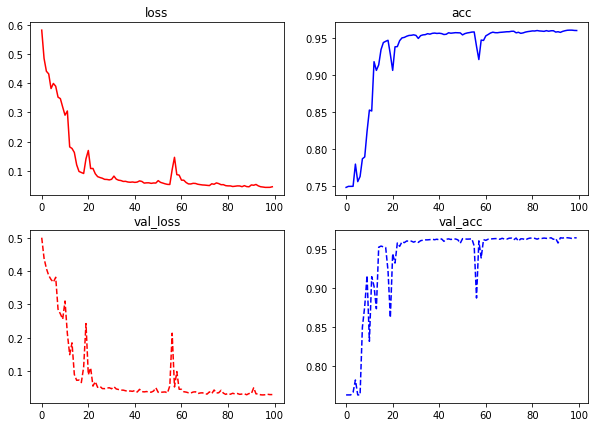

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

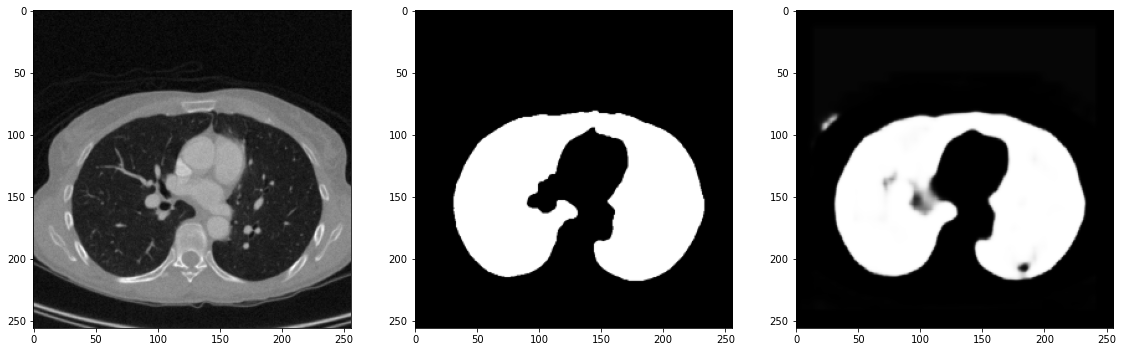

In [60]:
preds = model.predict(x_val)


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

i = 0
ax[0].imshow(x_val[i].squeeze(), cmap="gray")
ax[1].imshow(y_val[i].squeeze(), cmap="gray")
ax[2].imshow(pred.squeeze(), cmap="gray")

fig.tight_layout()
fig.subplots_adjust(left=0, bottom=0,  right=1, top=1, hspace=0.2, wspace=0.2)
fig.savefig(f"result_img{i}.png") # Image size 조절을 위해 figsize 조절 필요